### Project Objective
This notebook aims to build a predictive model to estimate hospital readmission outcomes for diabetes patients. The target variable, readmitted, has three classes: NO, <30 days, and >30 days.

Purpose: 
Accurate predictions of readmission risk can help hospitals allocate resources more efficiently. Patients identified as high risk (especially those likely to return within 30 days) can receive tailored interventions, improved monitoring, or optimized discharge planning. This may reduce unnecessary readmissions and improve bed and staff utilization.

### Note: Why the <30 Days Readmission Class Matters

Readmissions within 30 days are widely used in healthcare as a key quality indicator. They often signal unresolved medical issues, inadequate discharge planning, or complications that arise shortly after the patient leaves the hospital. Hospitals typically monitor this category closely because these readmissions are considered more preventable and are sometimes tied to financial or performance evaluations.
For this reason, achieving strong model performance on the <30 class is particularly valuable for clinical decision-making and resource planning.

### Dataset Information

Source

The dataset is sourced from Kaggle. A preprocessed version of the data is used in this notebook; missing values have been handled, relevant feature engineering has been performed, and unnecessary columns have been removed. We will load the dataset from the file cleaned_df.pkl.

What Each Row Represents

Each row corresponds to an individual patient encounter, containing demographic details, medical history, and hospital-related information such as medications, procedures, and diagnostic attributes.

Major Feature Categories:

1) Demographics (age, gender, race, etc.)

2) Medication-related variables

3) Lab tests and procedures

4) Encounter and admission details

Problem Type
This is a multiclass classification task in which the goal is to predict patient readmission outcomes into three categories: NO, <30 days, and >30 days.

# 1) Initial Data Checks
i) load the pickle file from ../Data/Processed/cleaned_df.pkl

ii) print head to check the contents and if the pickle file is loaded correctly

iii) review the structure and column types to get an idea about the dataframe and if it needs any further processing

iv) check the summary statistics to look for any unusal trends or patterns in the data

v) Check the distribution of the class variable to see if it balanced or unbalanced so that it could be handled accordingly during modelling step

# 2) Modelling Approach

i) Models to Try and Rationale

Begin with a simple baseline model such as Logistic Regression to establish reference performance using accuracy, precision, recall, and F1-score. If performance is limited, explore more complex algorithms including Support Vector Machines (SVM), Decision Trees, Random Forests, Bagging and Boosting methods, and Artificial Neural Networks (ANN). Each model will be tuned through appropriate hyperparameters to improve predictive performance.

ii) Data Splitting Strategy

Because this is a binary class classification problem, the dataset will be split into training and testing sets using a stratified train–test split to ensure the class proportions are preserved across both sets.

iii) Evaluation Metrics

Model performance will be evaluated using precision, recall, F1-score, and confusion matrices to understand class-wise behavior and overall predictive capability.

iv) Model Comparison Approach

Models will be compared using their confusion matrices and aggregate performance metrics. Special attention will be given to maintaining a strong balance between recall and F1-score, especially for the clinically important <30 days readmission class.

v) Constraints and Considerations

Potential class imbalance may affect model performance, particularly for minority classes. If needed, techniques such as class weighting or resampling will be considered during model development

# 3) Modelling Data Preparation

1. Feature Selection

All feature cleaning, removal of highly correlated variables, and elimination of irrelevant columns were completed during preprocessing. In this notebook, all remaining columns will be used as features, with readmitted serving as the target variable.

2. Handling Categorical and Numerical Variables

Numerical features: Standardized using StandardScaler.
Categorical features:
Low-cardinality categories: Encoded using One-Hot Encoding (OHE).
High-cardinality categories: Encoded using Target Encoding to reduce dimensionality and maintain signal strength.

3. Preprocessing Structure (Pipeline and ColumnTransformer)
A ColumnTransformer will be used to apply different transformations to numerical and categorical features.
A Pipeline will incorporate preprocessing and the selected model, ensuring consistent and reproducible transformations during training and evaluation.

4. Handling Class Imbalance
If class imbalance is observed, techniques such as SMOTE or alternative balancing strategies may be applied to improve minority-class performance.

5. Reproducibility
A fixed random_state will be used throughout the workflow, and the train–test split will be stratified to maintain class proportions in both sets.

# 4) Baseline Model plan (logistic Regression)

1. Purpose of the Baseline Model

i) Establish an initial performance benchmark for all subsequent models.

ii) Assess the overall difficulty of the prediction task.

iii) Gain early insights into data behavior and model fit, helping determine whether additional EDA or feature engineering may be needed.

2. Evaluation Metrics
The baseline model will be evaluated using:

i) Precision

ii) Recall

iii) F1-score

iv) Confusion matrix
These metrics will provide class-level insights, particularly for the clinically important <30 days readmission class.

3. Decisions Guided by the Baseline Results

i) Whether more complex models are required to improve performance.

ii) Whether class imbalance needs additional treatment (e.g., SMOTE, class weights).

iii) Whether the preprocessing pipeline (scaling, encoding) is functioning as expected.

# 5) Model Training Workflow Plan

i) Load the data

ii) Separate the target and feature columns

iii) Split into training and testing set

iv) Apply the column transformations

v) Train the baseline logistic regression

vi) Evaluate the base line model

vii) Iterate and tune the parameters

viii) Iterate with more models

ix) Compare performance across models

x) Choose final model

In [1]:
import pickle
with open('../Data/Processed/cleaned_df.pkl', 'rb') as f:
    cleaned_df=pickle.load(f)
print(cleaned_df.shape)
print(cleaned_df.head())
print(cleaned_df.info())
print(cleaned_df.describe())
print(cleaned_df['readmitted'].value_counts())

(101766, 50)
       patient_nbr       race  gender      age  weight  admission_type_id  \
4267           135  Caucasian  Female  [50-60)       0                  2   
4780           135  Caucasian  Female  [50-60)       0                  1   
5827           378  Caucasian  Female  [50-60)       0                  3   
67608          729  Caucasian  Female  [80-90)       0                  1   
17494          774  Caucasian  Female  [80-90)       0                  1   

       discharge_disposition_id  admission_source_id  time_in_hospital  \
4267                          1                    1                 8   
4780                          1                    7                 3   
5827                          1                    1                 2   
67608                         3                    7                 4   
17494                         1                    7                 3   

                     medical_specialty  ...  change  diabetesMed  readmitted  \

# Data Splitting into training and test set

## Patient ID Splitting is Required
Standard train_test_split operates randomly on rows, ignoring patient identity. Because we created powerful, sequential features based on patient history (patient_historical_readmission_rate), a random split will mix a patient's early encounters (past) into the Test Set and their later encounters (future) into the Training Set.

This causes a catastrophic form of data leakage, artificially inflating performance metrics (like precision and F1-score) because the model is tested on data it has implicitly seen (i.e., the future outcome of the same patient).

Solution: We must split the data at the Patient ID level, ensuring all encounters for a single patient reside entirely in either the Training Set or the Test Set.

Implementation: Patient-Level Train/Test Split
This process ensures that the Test Set contains truly "unseen" patients, providing an honest evaluation of the model's ability to generalize.

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
# -----------------------------------------------------------
# 1. Define Features (X) and Target (Y)
# -----------------------------------------------------------

# Columns that must be excluded from the Feature set (X)
COLUMNS_TO_EXCLUDE = [
    'readmitted',           # The original multi-class target
    'readmitted_30d',       # The binary target we will use (Y_binary)
    'cum_readmissions',     # Intermediate calculation column
    #'weight',             # Uncomment this line if you decide to drop 'weight' due to missingness
]

# Define the full feature set X, keeping 'patient_nbr' temporarily for the split
X_full = cleaned_df.drop(columns=COLUMNS_TO_EXCLUDE, errors='ignore')

# Define the binary target Y (1 for <30 days, 0 otherwise)
Y_binary = (cleaned_df['readmitted'] == '<30').astype(int)

# -----------------------------------------------------------
# 2. Patient-Level Split Logic (CRITICAL)
# -----------------------------------------------------------

# A. Identify the unique patient IDs
unique_patients = X_full['patient_nbr'].unique()

# B. Split the PATIENT IDs (NOT the rows)
# We use a random state for reproducibility
patient_train_ids, patient_test_ids = train_test_split(
    unique_patients, 
    test_size=0.2, 
    random_state=42 
)

# C. Filter the entire dataset based on the patient IDs
# --- Training Set ---
# X_train rows are those belonging to the training patient IDs
X_train = X_full[X_full['patient_nbr'].isin(patient_train_ids)].copy()
# y_train must align perfectly with X_train indices
y_train = Y_binary.loc[X_train.index].copy()

# --- Test Set ---
# X_test rows are those belonging to the test patient IDs
X_test = X_full[X_full['patient_nbr'].isin(patient_test_ids)].copy()
# y_test must align perfectly with X_test indices
y_test = Y_binary.loc[X_test.index].copy()

# -----------------------------------------------------------
# 3. Final Feature Cleanup: Drop Identifiers from X
# -----------------------------------------------------------
# The 'patient_nbr' column is only used for the split, NOT for model training!
X_train.drop('patient_nbr', axis=1, inplace=True)
X_test.drop('patient_nbr', axis=1, inplace=True)

# -----------------------------------------------------------
# 4. Verification and Output
# -----------------------------------------------------------
print("--- Data Split Summary ---")
print(f"Total encounters: {len(X_full)}")
print(f"Training encounters: {len(X_train)} (Unique Patients: {len(patient_train_ids)})")
print(f"Testing encounters: {len(X_test)} (Unique Patients: {len(patient_test_ids)})")
print("-" * 25)
print(f"X_train feature count: {X_train.shape[1]}")
print(f"X_train feature list: {list(X_train.columns)}")

--- Data Split Summary ---
Total encounters: 101766
Training encounters: 81613 (Unique Patients: 57214)
Testing encounters: 20153 (Unique Patients: 14304)
-------------------------
X_train feature count: 46
X_train feature list: ['race', 'gender', 'age', 'weight', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'time_in_hospital', 'medical_specialty', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'change', 'diabetesMed', 'patient_prior_encounters', 'patient_historical_readmission_rate', '

In [3]:
print(len(patient_train_ids) == len(set(patient_train_ids)))
print(len(patient_test_ids) == len(set(patient_test_ids)))

True
True


# Data Preprocessing

In [4]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, classification_report, confusion_matrix

# 1. Redefine Column Lists for Simplified Preprocessing
# Get all numerical columns
numeric_cols = X_train.select_dtypes(include=['int64','float64']).columns.tolist()
# Combine ALL categorical columns for safe OHE in the LogReg baseline
categorical_cols = X_train.select_dtypes(include='object').columns.tolist()

# 2. Define Preprocessor for Logistic Regression 
preprocess = ColumnTransformer(transformers=[
    ("numeric_cols", StandardScaler(), numeric_cols),
    
    ("categorical_cols", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_cols)
])


In [5]:
from sklearn import set_config
set_config(display="diagram")

# Logistic Regression

In [104]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pprint
from typing import Union, Dict, Any, Tuple # Keeping type hints here is good practice

# Scikit-learn imports
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,classification_report, confusion_matrix, roc_curve, roc_auc_score)
from sklearn.compose import ColumnTransformer

def plot_coefficients(pipe: Pipeline, n_top_features: int = 10) -> plt.Figure:
    """Extracts and plots the top N absolute coefficients, returning the Figure object."""
    
    logreg_model = pipe['logistic_regression']
    feature_names = pipe['preprocess'].get_feature_names_out()
    coefficients = logreg_model.coef_[0]
    coef_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefficients,
        'Absolute_Coefficient': np.abs(coefficients)
    })
    # Sort and select top N features by absolute value
    plot_data = coef_df.sort_values(by='Absolute_Coefficient', ascending=False).head(n_top_features)
    fig = plt.figure(figsize=(10, 6))
    sns.barplot(x='Coefficient', y='Feature', data=plot_data)
    plt.title(f'Top {n_top_features} Logistic Regression Feature Coefficients')
    plt.xlabel('Coefficient Value (Positive = Class 1 Likelihood)')
    plt.grid(axis='x', linestyle='--')    
    return fig

def plot_roc_curve(pipe: Pipeline, X_test: Union[pd.DataFrame, np.ndarray], y_test: Union[pd.Series, np.ndarray]) -> plt.Figure:
    """Calculates and plots the ROC curve, returning the Figure object."""
    # Get probability predictions for the positive class (Class 1)
    y_proba = pipe.predict_proba(X_test)[:, 1]
    # Calculate performance metrics
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    roc_auc = roc_auc_score(y_test, y_proba)
    fig = plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess (AUC = 0.5)')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")    
    return fig
import numpy as np
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score

def threshold_metrics(pipe: Pipeline, X_test, y_test):
    y_proba = pipe.predict_proba(X_test)[:, 1]

    thresholds = np.arange(0.05, 1.01, 0.05)
    rows = []

    for t in thresholds:
        y_pred = (y_proba >= t).astype(int)

        rows.append({
            "Threshold": round(t, 2),
            "Precision": precision_score(y_test, y_pred, zero_division=0),
            "Recall": recall_score(y_test, y_pred),
            "F1": f1_score(y_test, y_pred),
            "Positive Rate": y_pred.mean()   # % of population flagged diabetic
        })

    return pd.DataFrame(rows)

def run_logistic_regression(preprocess, X_train, y_train, X_test, y_test, logreg_params=None, output_dir="../Outputs/Logistic_Regression"):
    
    default_logreg_params = {"C": 1.0, "penalty": "l2", "solver": "lbfgs"}
    if logreg_params is None:
        logreg_params = default_logreg_params

    log_reg = LogisticRegression(max_iter=300, class_weight="balanced", random_state=42, **logreg_params)
    pipe = Pipeline(steps=[("preprocess", preprocess), ("logistic_regression", log_reg)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    metrics = {
        "accuracy": accuracy_score(y_test, y_pred), 
        "precision_macro": precision_score(y_test, y_pred, average="macro"),
        "recall_macro": recall_score(y_test, y_pred, average="macro"),
        "f1_score_macro": f1_score(y_test, y_pred, average="macro"),
        "classification_report": classification_report(y_test, y_pred, output_dict=True),
        "confusion_matrix": confusion_matrix(y_test, y_pred)
    }

    print("\n--- Evaluation Summary (Logistic Regression) ---")
    print(f"Parameters Used: {logreg_params}")
    
    print("\n--- Detailed Evaluation Metrics ---")
    pprint.pprint(metrics)
    
    # Create Directory
    try:
        os.makedirs(output_dir, exist_ok=True)
        print(f"\nResults will be saved in: {os.path.abspath(output_dir)}")
    except OSError as e:
        print(f"Error creating directory: {e}")

    # Generate and Save Plots
    print("\n--- Generating Model Insights Plots... ---")
    
    # Generate and save Coefficient Plot
    coef_fig = plot_coefficients(pipe)
    coef_fig.savefig(os.path.join(output_dir, "feature_coefficients.png"), bbox_inches='tight')
    plt.show()
    plt.close(coef_fig) 
    
    # Generate and save ROC Curve Plot
    roc_fig = plot_roc_curve(pipe, X_test, y_test)
    roc_fig.savefig(os.path.join(output_dir, "roc_curve.png"), bbox_inches='tight')
    plt.show()
    plt.close(roc_fig) 
    
    # Save the Metrics (SIMPLE TXT FILE)
    metrics_filename = os.path.join(output_dir, "metrics.txt")
    try:
        metrics_string = pprint.pformat(metrics)
        
        with open(metrics_filename, 'w') as f:
            f.write("--- Logistic Regression Evaluation Metrics ---\n\n")
            f.write(metrics_string)
            
        print("Metrics (TXT) saved successfully.")
    except Exception as e:
        print(f"Error saving metrics to TXT file: {e}")
    
    # -------- Threshold-level performance --------
    print("\n--- Threshold Analysis ---")
    threshold_df = threshold_metrics(pipe, X_test, y_test)
    print(threshold_df)

    # Save threshold table
    threshold_path = os.path.join(output_dir, "threshold_metrics.csv")
    threshold_df.to_csv(threshold_path, index=False)
    print(f"Threshold metrics saved to: {threshold_path}")

    return pipe, metrics

/Users/iti/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



--- Evaluation Summary (Logistic Regression) ---
Parameters Used: {'solver': 'saga'}

--- Detailed Evaluation Metrics ---
{'accuracy': 0.6599513720041681,
 'classification_report': {'0': {'f1-score': 0.7804018329221009,
                                 'precision': 0.9221507004922378,
                                 'recall': 0.6764248416842573,
                                 'support': 18002.0},
                           '1': {'f1-score': 0.24684031212221122,
                                 'precision': 0.16162924582613702,
                                 'recall': 0.5220827522082753,
                                 'support': 2151.0},
                           'accuracy': 0.6599513720041681,
                           'macro avg': {'f1-score': 0.513621072522156,
                                         'precision': 0.5418899731591874,
                                         'recall': 0.5992537969462663,
                                         'support': 20153.0},
         

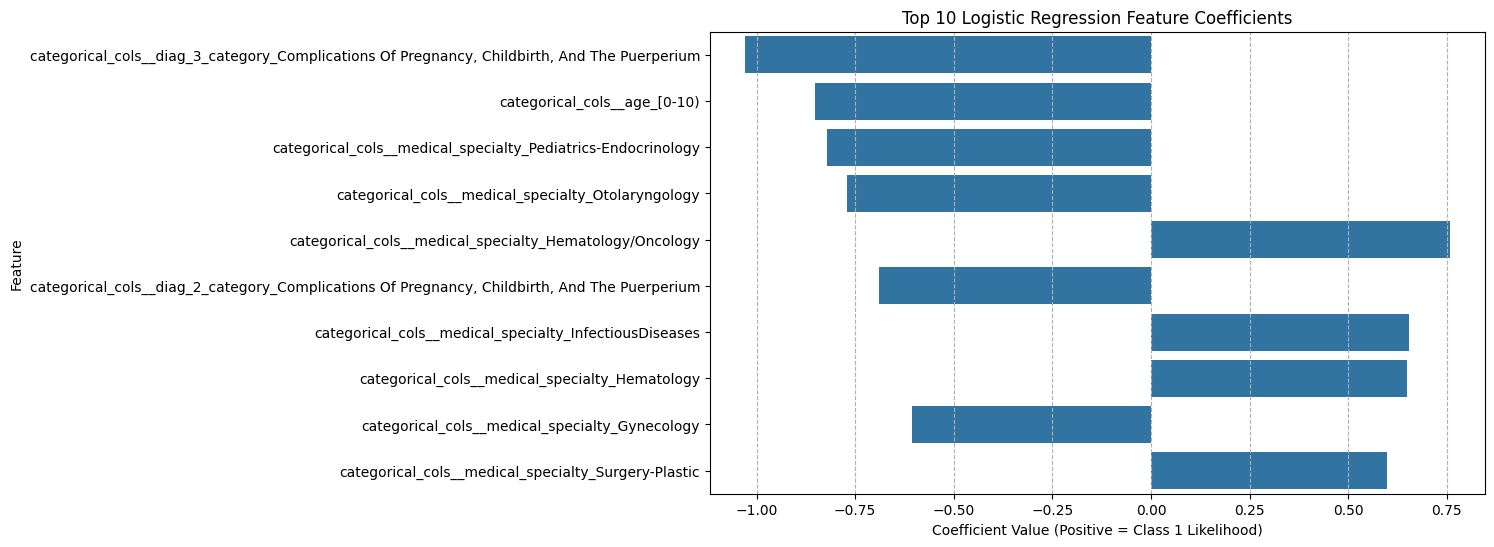

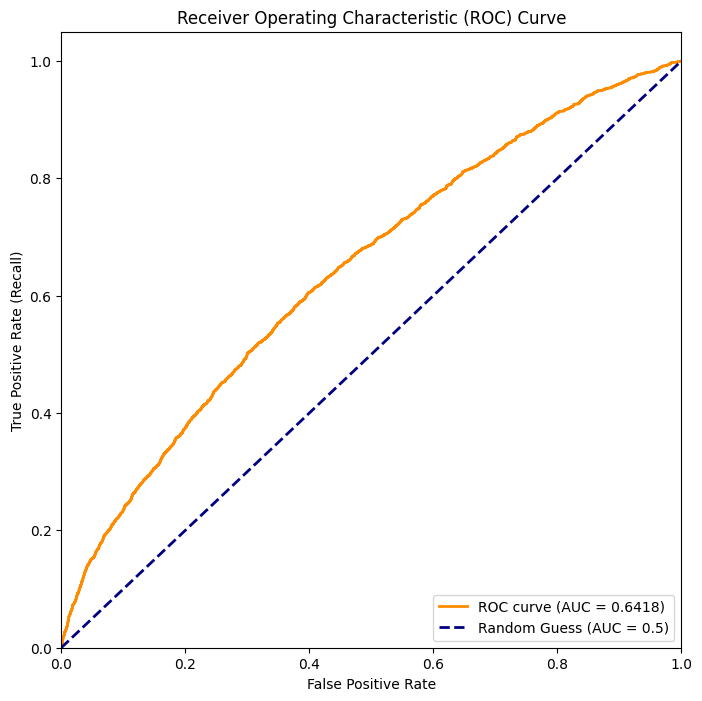

Metrics (TXT) saved successfully.

--- Threshold Analysis ---
    Threshold  Precision    Recall        F1  Positive Rate
0        0.05   0.106733  1.000000  0.192880       1.000000
1        0.10   0.106816  0.999535  0.193007       0.998759
2        0.15   0.107065  0.999070  0.193403       0.995981
3        0.20   0.107461  0.997675  0.194024       0.990919
4        0.25   0.108219  0.993491  0.195178       0.979854
5        0.30   0.110627  0.980009  0.198812       0.945517
6        0.35   0.117163  0.939098  0.208333       0.855505
7        0.40   0.126276  0.833566  0.219327       0.704560
8        0.45   0.141473  0.685728  0.234555       0.517342
9        0.50   0.161629  0.522083  0.246840       0.344763
10       0.55   0.182771  0.372850  0.245297       0.217734
11       0.60   0.210507  0.266388  0.235173       0.135067
12       0.65   0.248043  0.191539  0.216159       0.082419
13       0.70   0.286788  0.124128  0.173264       0.046197
14       0.75   0.304267  0.076244  0.

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('numeric_cols',
                                                  StandardScaler(),
                                                  ['weight',
                                                   'admission_type_id',
                                                   'discharge_disposition_id',
                                                   'admission_source_id',
                                                   'time_in_hospital',
                                                   'num_lab_procedures',
                                                   'num_procedures',
                                                   'num_medications',
                                                   'number_outpatient',
                                                   'number_emergency',
                                                   'number_inpatient',
                                                   'number_diagnoses',
                                                   'patient_prior_encounter...
                                                   'rosiglitazone', 'acarbose',
                                                   'miglitol', 'troglitazone',
                                                   'tolazamide', 'insulin',
                                                   'glyburide-metformin',
                                                   'glipizide-metformin',
                                                   'glimepiride-pioglitazone',
                                                   'metformin-rosiglitazone',
                                                   'metformin-pioglitazone',
                                                   'change', 'diabetesMed',
                                                   'diag_1_category', ...])])),
                ('logistic_regression',
                 LogisticRegression(class_weight='balanced', max_iter=300,
                                    random_state=42, solver='saga'))])

In [105]:
log_reg_pipe, evaluation_results = run_logistic_regression(preprocess,X_train,y_train,X_test,y_test,logreg_params={'solver': 'saga'})
log_reg_pipe

## Interpretaion of the results of logistic regression model
Feature importance plot: 
The Y-axis shows the top 10 most impactful features that are influencing the class 1 (<30). The X-axis shows the coef values which determine the direction of the influence; the sign + or - are infuencing the prediction of class 1 in that manner. In summary: The model is likely trying to predict which patients will be readmitted within a month of discharge, and it has correctly identified that patients with Oncology issues are high-risk (Class 1) and patients with Obstetrics/Childbirth issues are low-risk (Class 0).

ROC Curve: The curve illustrates the trade-off between the ability to correctly identify positive instances (high TPR) and the ability to avoid misclassifying negative instances (low FPR). 

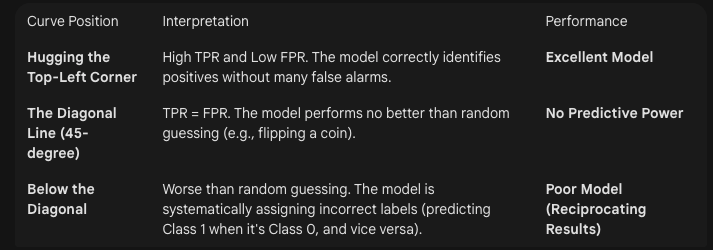

The single most important metric derived from the ROC curve is the Area Under the ROC Curve (AUC). The AUC is a single scalar value (ranging from 0.5 to 1.0) that summarizes the model's overall ability to discriminate between the positive and negative classes across all possible thresholds.

Interpretation as a Probability: A common interpretation is that the AUC represents the probability that the model will rank a randomly chosen positive instance higher than a randomly chosen negative instance.

AUC = 1.0: Perfect classification.

AUC = 0.9: Excellent discrimination (90% chance of correctly ranking a positive higher than a negative).

AUC = 0.5: Random guessing.

The ROC-AUC of 0.64 indicates the model has learned some signal but its discriminative power is still limited. In particular, at low false-positive rates the recall is poor, which is problematic for a screening task. This suggests we need to improve feature representation and model capacity before optimizing decision thresholds.

In [92]:
import pandas as pd
import numpy as np

# 1. Transform and Create DataFrame
X_train_df_processed = pd.DataFrame(
    preprocess.fit_transform(X_train),
    columns=preprocess.get_feature_names_out()
)

# 2. Calculate Absolute Correlation and Filter (Threshold: 0.7)
corr_abs = X_train_df_processed.corr().abs()
THRESHOLD = 0.2
np.fill_diagonal(corr_abs.values, 0)

high_pairs = []
cols = corr_abs.columns

for i in range(len(cols)):
    for j in range(i+1, len(cols)):
        val = corr_abs.iloc[i, j]
        if val >= THRESHOLD:
            high_pairs.append((cols[i], cols[j], val))

high_corr_df = pd.DataFrame(high_pairs, columns=["var1","var2","corr"])
high_corr_df.sort_values("corr", ascending=False)

,var1,var2,corr
122,categorical_cols__diabetesMed_No,categorical_cols__diabetesMed_Yes,1.000000
95,categorical_cols__tolazamide_No,categorical_cols__tolazamide_Steady,1.000000
114,categorical_cols__glipizide-metformin_No,categorical_cols__glipizide-metformin_Steady,1.000000
86,categorical_cols__tolbutamide_No,categorical_cols__tolbutamide_Steady,1.000000
116,categorical_cols__metformin-rosiglitazone_No,categorical_cols__metformin-rosiglitazone_Steady,1.000000
...,...,...,...
55,categorical_cols__medical_specialty_Psychology,categorical_cols__diag_1_category_Mental Disor...,0.203380
101,categorical_cols__insulin_Down,categorical_cols__diabetesMed_Yes,0.202080
100,categorical_cols__insulin_Down,categorical_cols__diabetesMed_No,0.202080
88,categorical_cols__pioglitazone_No,categorical_cols__change_Ch,0.201932


# For imbalanced dataset apply SMOTE

In [25]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression

pipe_smote = Pipeline(steps=[
    ("preprocess", preprocess),
    ("smote", SMOTE(random_state=42)),
    ("model", LogisticRegression(max_iter=300, random_state=42))
])

pipe_smote.fit(X_train, y_train)
y_pred_smote = pipe_smote.predict(X_test)
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, classification_report, confusion_matrix
print("accuracy",accuracy_score(y_test,y_pred_smote))
print("precision", precision_score(y_test,y_pred_smote, average='macro'))
print("F1 Score", f1_score(y_test,y_pred_smote, average='macro'))
print("Recall", recall_score(y_test,y_pred_smote, average='macro'))
print("classification report", classification_report(y_test,y_pred_smote))
print("confusion_matrix", confusion_matrix(y_test,y_pred_smote))

accuracy 0.6286905175408127
precision 0.533937923427255
F1 Score 0.4937030098509201
Recall 0.583597819158582
classification report               precision    recall  f1-score   support

           0       0.92      0.64      0.76     18002
           1       0.15      0.53      0.23      2151

    accuracy                           0.63     20153
   macro avg       0.53      0.58      0.49     20153
weighted avg       0.84      0.63      0.70     20153

confusion_matrix [[11538  6464]
 [ 1019  1132]]


In [26]:
# Decision Tree – Baseline Model
# This Decision Tree baseline is used to test whether non-linear rules and feature interactions improve early readmission prediction compared to Logistic Regression
from sklearn.tree import DecisionTreeClassifier
pipe=Pipeline(steps=[("preprocess", preprocess),
                     ("Decision_tree", DecisionTreeClassifier(class_weight="balanced",max_depth=5,random_state=42, min_samples_leaf=100))]
)
pipe.fit(X_train,y_train)
y_pred=pipe.predict(X_test)
# The baseline Decision Tree model underperforms Logistic Regression, particularly for the clinically important <30 readmission class, 
# indicating that a single tree is too unstable to capture the complex patterns required for early readmission prediction.
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, classification_report, confusion_matrix
print("accuracy",accuracy_score(y_test,y_pred))
print("precision", precision_score(y_test,y_pred, average='macro'))
print("F1 Score", f1_score(y_test,y_pred, average='macro'))
print("Recall", recall_score(y_test,y_pred, average='macro'))
print("classification report", classification_report(y_test,y_pred))
print("confusion_matrix", confusion_matrix(y_test,y_pred))

accuracy 0.6076514662829355
precision 0.5451996414304182
F1 Score 0.4938485613619674
Recall 0.6154171954962802
classification report               precision    recall  f1-score   support

           0       0.93      0.61      0.73     18002
           1       0.16      0.63      0.25      2151

    accuracy                           0.61     20153
   macro avg       0.55      0.62      0.49     20153
weighted avg       0.85      0.61      0.68     20153

confusion_matrix [[10901  7101]
 [  806  1345]]


In [27]:
# Random Forest – Baseline Model
from sklearn.ensemble import RandomForestClassifier
pipe=Pipeline(steps=[("preprocess", preprocess),
                     ("Random_forest", RandomForestClassifier(random_state=42, class_weight='balanced', n_estimators=500,max_depth=8,min_samples_leaf=50))])

pipe.fit(X_train,y_train)
y_pred=pipe.predict(X_test)
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, classification_report, confusion_matrix
print("accuracy",accuracy_score(y_test,y_pred))
print("precision", precision_score(y_test,y_pred, average='macro'))
print("F1 Score", f1_score(y_test,y_pred, average='macro'))
print("Recall", recall_score(y_test,y_pred, average='macro'))
print("classification report", classification_report(y_test,y_pred))
print("confusion_matrix", confusion_matrix(y_test,y_pred))
# Neither SMOTE nor cost-sensitive learning improved Random Forest performance on the <30 class, 
# indicating that early readmissions are not well separated by rule-based splits. 
# This suggests that the predictive signal for <30 is subtle and overlapping, motivating the use of boosting-based methods that focus on hard-to-classify samples.

accuracy 0.6619361881605716
precision 0.5440061462576745
F1 Score 0.5163846845702873
Recall 0.6042536159136407
classification report               precision    recall  f1-score   support

           0       0.92      0.68      0.78     18002
           1       0.16      0.53      0.25      2151

    accuracy                           0.66     20153
   macro avg       0.54      0.60      0.52     20153
weighted avg       0.84      0.66      0.73     20153

confusion_matrix [[12198  5804]
 [ 1009  1142]]


In [29]:
# Gradient Boosting - Baseline Model
from sklearn.ensemble import GradientBoostingClassifier
pipe=Pipeline(steps=[
    ('preprocess', preprocess),
    ('Gradient_boost', GradientBoostingClassifier(random_state=42))
])
pipe.fit(X_train,y_train)
y_pred=pipe.predict(X_test)
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, classification_report, confusion_matrix
print("accuracy",accuracy_score(y_test,y_pred))
print("precision", precision_score(y_test,y_pred, average='macro'))
print("F1 Score", f1_score(y_test,y_pred, average='macro'))
print("Recall", recall_score(y_test,y_pred, average='macro'))
print("classification report", classification_report(y_test,y_pred))
print("confusion_matrix", confusion_matrix(y_test,y_pred))
# Across multiple model families, tree-based and ensemble methods failed to recover early readmission signals, consistently collapsing the <30 class despite imbalance handling. 
# In contrast, Logistic Regression demonstrated superior recall for early readmissions, indicating that the predictive signal for <30 is weak, 
# overlapping, and better captured through additive linear effects rather than rule-based splits.

accuracy 0.8933657519972212
precision 0.7196002546953816
F1 Score 0.47734462551317686
Recall 0.5025116533619308
classification report               precision    recall  f1-score   support

           0       0.89      1.00      0.94     18002
           1       0.55      0.01      0.01      2151

    accuracy                           0.89     20153
   macro avg       0.72      0.50      0.48     20153
weighted avg       0.86      0.89      0.84     20153

confusion_matrix [[17992    10]
 [ 2139    12]]


In [ ]:
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, classification_report, confusion_matrix

# --- 1. Define Column Lists (Same as before, ensuring consistency) ---
# Assuming X_train, y_train, X_test, y_test are ready from the patient-split step

numeric_cols = X_train.select_dtypes(include=['int64','float64']).columns.tolist()
categorical_cols = X_train.select_dtypes(include='object').columns.tolist()


# 2. Define Preprocessor for XGBoost (No Scaling)
# Tree models do not require scaling, so we use 'passthrough' for numerical features.
xgb_preprocess = ColumnTransformer(transformers=[
    # Numeric features: Pass through (no scaling needed for tree-based models)
    ("numeric_cols", 'passthrough', numeric_cols), 
    
    # Categorical features: Use OneHotEncoder (OHE)
    # XGBoost can often handle OHE or Label Encoding, OHE is safer and more general.
    ("categorical_cols", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_cols)
])


# 3. Calculate Imbalance Weight (scale_pos_weight)
# This parameter tells the model how much more important the positive class (1) is.
neg_count = y_train.value_counts()[0]  # Count of Class 0 (NO readmission)
pos_count = y_train.value_counts()[1]  # Count of Class 1 (<30 readmission)
scale_pos_weight = neg_count / pos_count

print(f"\n--- Training XGBoost Classifier ---")
print(f"Calculated scale_pos_weight (Negative/Positive Ratio): {scale_pos_weight:.2f}")

# 4. Create and Train Pipeline
pipe_xgb = Pipeline(steps=[
    ("preprocess", xgb_preprocess),
    ("xgb_classifier", xgb.XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        use_label_encoder=False,
        scale_pos_weight=scale_pos_weight, # Handles the class imbalance
        random_state=42,
        n_estimators=500, # Increased estimators for potentially better performance
        learning_rate=0.05,
        max_depth=5, # A good starting depth for complexity
        tree_method='hist' # Faster training on larger datasets
    ))
])

pipe_xgb.fit(X_train, y_train)
y_pred_xgb = pipe_xgb.predict(X_test)


# 5. Evaluate XGBoost
print("\n--- Evaluation (XGBoost Classifier) ---")
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("Precision (Macro):", precision_score(y_test, y_pred_xgb, average='macro'))
print("F1 Score (Macro):", f1_score(y_test, y_pred_xgb, average='macro'))
print("Recall (Macro):", recall_score(y_test, y_pred_xgb, average='macro'))
print("\nClassification Report (Focus on minority class '1'):\n", classification_report(y_test, y_pred_xgb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))


--- Training XGBoost Classifier ---
Calculated scale_pos_weight (Negative/Positive Ratio): 7.87


/Users/iti/miniconda3/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [14:28:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- Evaluation (XGBoost Classifier) ---
Accuracy: 0.6658065796655585
Precision (Macro): 0.5525744838661102
F1 Score (Macro): 0.525889952800657
Recall (Macro): 0.625454847699912

Classification Report (Focus on minority class '1'):
               precision    recall  f1-score   support

           0       0.93      0.68      0.78     18002
           1       0.18      0.57      0.27      2151

    accuracy                           0.67     20153
   macro avg       0.55      0.63      0.53     20153
weighted avg       0.85      0.67      0.73     20153

Confusion Matrix:
 [[12183  5819]
 [  916  1235]]


In [ ]:
from sklearn.metrics import precision_recall_curve

# 1. Get Prediction Probabilities from the trained XGBoost pipeline
# We are interested in the probability of the positive class (index 1)
y_proba_xgb = pipe_xgb.predict_proba(X_test)[:, 1]

# 2. Calculate Precision, Recall, and Thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_proba_xgb)

# 3. Calculate F1 Score for every threshold
f1_scores = 2 * (precision * recall) / (precision + recall)
f1_scores = np.nan_to_num(f1_scores) # Handle division by zero warning

# 4. Find the optimal threshold that maximizes the F1 Score
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]
max_f1 = f1_scores[optimal_idx]

# 5. Apply the optimal threshold to the test set
y_pred_optimal = (y_proba_xgb >= optimal_threshold).astype(int)

# 6. Evaluate using the Optimal Threshold
print("\n--- Threshold Optimization Results ---")
print(f"Optimal Threshold Found: {optimal_threshold:.4f}")
print(f"Maximum F1-Score Achieved: {max_f1:.4f}")

print("\n--- Evaluation (XGBoost with Optimal Threshold) ---")
print("Accuracy:", accuracy_score(y_test, y_pred_optimal))
print("F1 Score (Macro):", f1_score(y_test, y_pred_optimal, average='macro'))
print("Recall (Macro):", recall_score(y_test, y_pred_optimal, average='macro'))
print("Classification Report:\n", classification_report(y_test, y_pred_optimal))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_optimal))


--- Threshold Optimization Results ---
Optimal Threshold Found: 0.5696
Maximum F1-Score Achieved: 0.2749

--- Evaluation (XGBoost with Optimal Threshold) ---
Accuracy: 0.7738301989778197
F1 Score (Macro): 0.5704582919257505
Recall (Macro): 0.6099858035299658
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.82      0.87     18002
           1       0.21      0.40      0.27      2151

    accuracy                           0.77     20153
   macro avg       0.56      0.61      0.57     20153
weighted avg       0.84      0.77      0.80     20153

Confusion Matrix:
 [[14731  3271]
 [ 1287   864]]


/var/folders/kn/l8641p151k93sbb2vg6hs5ph0000gn/T/ipykernel_35033/1855408741.py:11: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_recall_curve, f1_score, recall_score,
    classification_report, confusion_matrix
)
from scipy.stats import uniform, randint
import time


# --- 1. Define the Parameter Search Space ---
# NOTE: Parameters must be prefixed with the step name if inside a Pipeline (e.g., 'xgb_classifier__max_depth')
param_dist = {
    # Tree Structure
    'xgb_classifier__max_depth': randint(4, 10),
    'xgb_classifier__min_child_weight': randint(1, 6),
    'xgb_classifier__gamma': uniform(0, 0.5),

    # Regularization & Learning
    'xgb_classifier__learning_rate': uniform(0.01, 0.1),
    'xgb_classifier__lambda': uniform(0.5, 2),
    'xgb_classifier__alpha': uniform(0.5, 2),

    # Subsampling
    'xgb_classifier__subsample': uniform(0.6, 0.3),
    'xgb_classifier__colsample_bytree': uniform(0.6, 0.3)
}

# --- 2. Setup and Execute Randomized Search ---

# We maximize the 'f1' score for the minority class (assuming positive class is 1)
random_search = RandomizedSearchCV(
    estimator=pipe_xgb,
    param_distributions=param_dist,
    n_iter=50,                  # Number of parameter settings sampled
    scoring='f1',               # Metric to maximize: F1-Score
    cv=5,                       # 5-fold cross-validation
    verbose=1,
    random_state=42,
    n_jobs=-1                   # Use all available cores
)

print("\n--- Starting Randomized Hyperparameter Search ---")
start_time = time.time()
random_search.fit(X_train, y_train) # Fit on the training data
end_time = time.time()

print(f"Search completed in: {(end_time - start_time) / 60:.2f} minutes")
print("\n--- Best Parameters Found ---")
print(random_search.best_params_)
print(f"Best CV F1-Score: {random_search.best_score_:.4f}")

# --- 3. Get the Best Model ---
# This is the model trained on the full training set using the best parameters
best_xgb_model = random_search.best_estimator_

# --- 4. Optimal Threshold Evaluation (Sticking to your original code logic) ---

# 4.1 Get Prediction Probabilities from the best trained pipeline
y_proba_xgb = best_xgb_model.predict_proba(X_test)[:, 1]

# 4.2 Calculate Precision, Recall, and Thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_proba_xgb)

# 4.3 Calculate F1 Score for every threshold
f1_scores = 2 * (precision * recall) / (precision + recall)
f1_scores = np.nan_to_num(f1_scores) 

# 4.4 Find the optimal threshold that maximizes the F1 Score
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]
max_f1 = f1_scores[optimal_idx]

# 4.5 Apply the optimal threshold to the test set
y_pred_optimal = (y_proba_xgb >= optimal_threshold).astype(int)

# 4.6 Evaluate using the Optimal Threshold
print("\n--- Threshold Optimization Results ---")
print(f"Optimal Threshold Found: {optimal_threshold:.4f}")
print(f"Maximum F1-Score Achieved: {max_f1:.4f}")

print("\n--- Evaluation (Tuned XGBoost with Optimal Threshold) ---")
print("Accuracy:", accuracy_score(y_test, y_pred_optimal))
print("F1 Score (Macro):", f1_score(y_test, y_pred_optimal, average='macro'))
print("Recall (Macro):", recall_score(y_test, y_pred_optimal, average='macro'))
print("Classification Report:\n", classification_report(y_test, y_pred_optimal))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_optimal))


--- Starting Randomized Hyperparameter Search ---
Fitting 5 folds for each of 50 candidates, totalling 250 fits


/Users/iti/miniconda3/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [14:57:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/iti/miniconda3/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [14:57:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/iti/miniconda3/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [14:57:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/iti/miniconda3/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [14:57:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bs

Search completed in: 7.06 minutes

--- Best Parameters Found ---
{'xgb_classifier__alpha': np.float64(1.825044568707964), 'xgb_classifier__colsample_bytree': np.float64(0.6935133228268233), 'xgb_classifier__gamma': np.float64(0.2600340105889054), 'xgb_classifier__lambda': np.float64(1.5934205586865593), 'xgb_classifier__learning_rate': np.float64(0.028485445552552703), 'xgb_classifier__max_depth': 5, 'xgb_classifier__min_child_weight': 2, 'xgb_classifier__subsample': np.float64(0.7349262400109297)}
Best CV F1-Score: 0.2769

--- Threshold Optimization Results ---
Optimal Threshold Found: 0.5599
Maximum F1-Score Achieved: 0.2796

--- Evaluation (Tuned XGBoost with Optimal Threshold) ---
Accuracy: 0.7619213020393986
F1 Score (Macro): 0.5684885949969467
Recall (Macro): 0.6170331247351978
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.80      0.86     18002
           1       0.21      0.43      0.28      2151

    accuracy     

/var/folders/kn/l8641p151k93sbb2vg6hs5ph0000gn/T/ipykernel_35033/1382845818.py:91: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


In [30]:
##Use kurtosis to check the data distribution of numerical columns
import pandas as pd
from scipy.stats import kurtosis

kurtosis_df = pd.DataFrame({
    "feature": numeric_cols,
    "kurtosis": [
        kurtosis(X_train[col].dropna(), fisher=True)
        for col in numeric_cols
    ]
}).sort_values("kurtosis", ascending=False)

kurtosis_df


,feature,kurtosis
9,number_emergency,1276.962180
8,number_outpatient,145.983075
12,patient_prior_encounters,68.459975
0,weight,26.374356
10,number_inpatient,22.057557
13,patient_historical_readmission_rate,8.469911
2,discharge_disposition_id,6.002153
7,num_medications,3.557642
1,admission_type_id,1.910007
3,admission_source_id,1.729944


| Kurtosis (Fisher) | Interpretation | Recommended Transform         |
| ----------------- | -------------- | ----------------------------- |
| > +1              | Heavy-tailed   | `log1p` or `PowerTransformer` |
| −1 to +1          | Near-normal    | `StandardScaler`              |
| < −1              | Light-tailed   | Usually no transform          |


In [31]:
high_kurtosis_cols = kurtosis_df.loc[
    kurtosis_df["kurtosis"] > 1, "feature"
].tolist()

normal_kurtosis_cols = kurtosis_df.loc[
    kurtosis_df["kurtosis"].between(-1, 1), "feature"
].tolist()


In [33]:
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.compose import ColumnTransformer

preprocess = ColumnTransformer(transformers=[
    ("num_normal", StandardScaler(), normal_kurtosis_cols),
    ("num_heavy", PowerTransformer(method="yeo-johnson"), high_kurtosis_cols),
    ("categorical_cols", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_cols)])


In [34]:
pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LogisticRegression(
        class_weight="balanced",
        random_state=42
    ))
])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, classification_report, confusion_matrix
print("accuracy",accuracy_score(y_test,y_pred))
print("precision", precision_score(y_test,y_pred, average='macro'))
print("F1 Score", f1_score(y_test,y_pred, average='macro'))
print("Recall", recall_score(y_test,y_pred, average='macro'))
print("classification report", classification_report(y_test,y_pred))
print("confusion_matrix", confusion_matrix(y_test,y_pred))

accuracy 0.637870292264179
precision 0.541150331337386
F1 Score 0.5039601476913605
Recall 0.6010166570158975
classification report               precision    recall  f1-score   support

           0       0.92      0.65      0.76     18002
           1       0.16      0.55      0.25      2151

    accuracy                           0.64     20153
   macro avg       0.54      0.60      0.50     20153
weighted avg       0.84      0.64      0.71     20153

confusion_matrix [[11663  6339]
 [  959  1192]]


/Users/iti/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [35]:
from sklearn.tree import DecisionTreeClassifier
pipe=Pipeline(steps=[("preprocess", preprocess),
                     ("Decision_tree", DecisionTreeClassifier(class_weight="balanced",max_depth=5,random_state=42, min_samples_leaf=100))]
)
pipe.fit(X_train,y_train)
y_pred=pipe.predict(X_test)
# The baseline Decision Tree model underperforms Logistic Regression, particularly for the clinically important <30 readmission class, 
# indicating that a single tree is too unstable to capture the complex patterns required for early readmission prediction.
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, classification_report, confusion_matrix
print("accuracy",accuracy_score(y_test,y_pred))
print("precision", precision_score(y_test,y_pred, average='macro'))
print("F1 Score", f1_score(y_test,y_pred, average='macro'))
print("Recall", recall_score(y_test,y_pred, average='macro'))
print("classification report", classification_report(y_test,y_pred))
print("confusion_matrix", confusion_matrix(y_test,y_pred))

accuracy 0.6076514662829355
precision 0.5451996414304182
F1 Score 0.4938485613619674
Recall 0.6154171954962802
classification report               precision    recall  f1-score   support

           0       0.93      0.61      0.73     18002
           1       0.16      0.63      0.25      2151

    accuracy                           0.61     20153
   macro avg       0.55      0.62      0.49     20153
weighted avg       0.85      0.61      0.68     20153

confusion_matrix [[10901  7101]
 [  806  1345]]


# create a bar plot and compare all the models
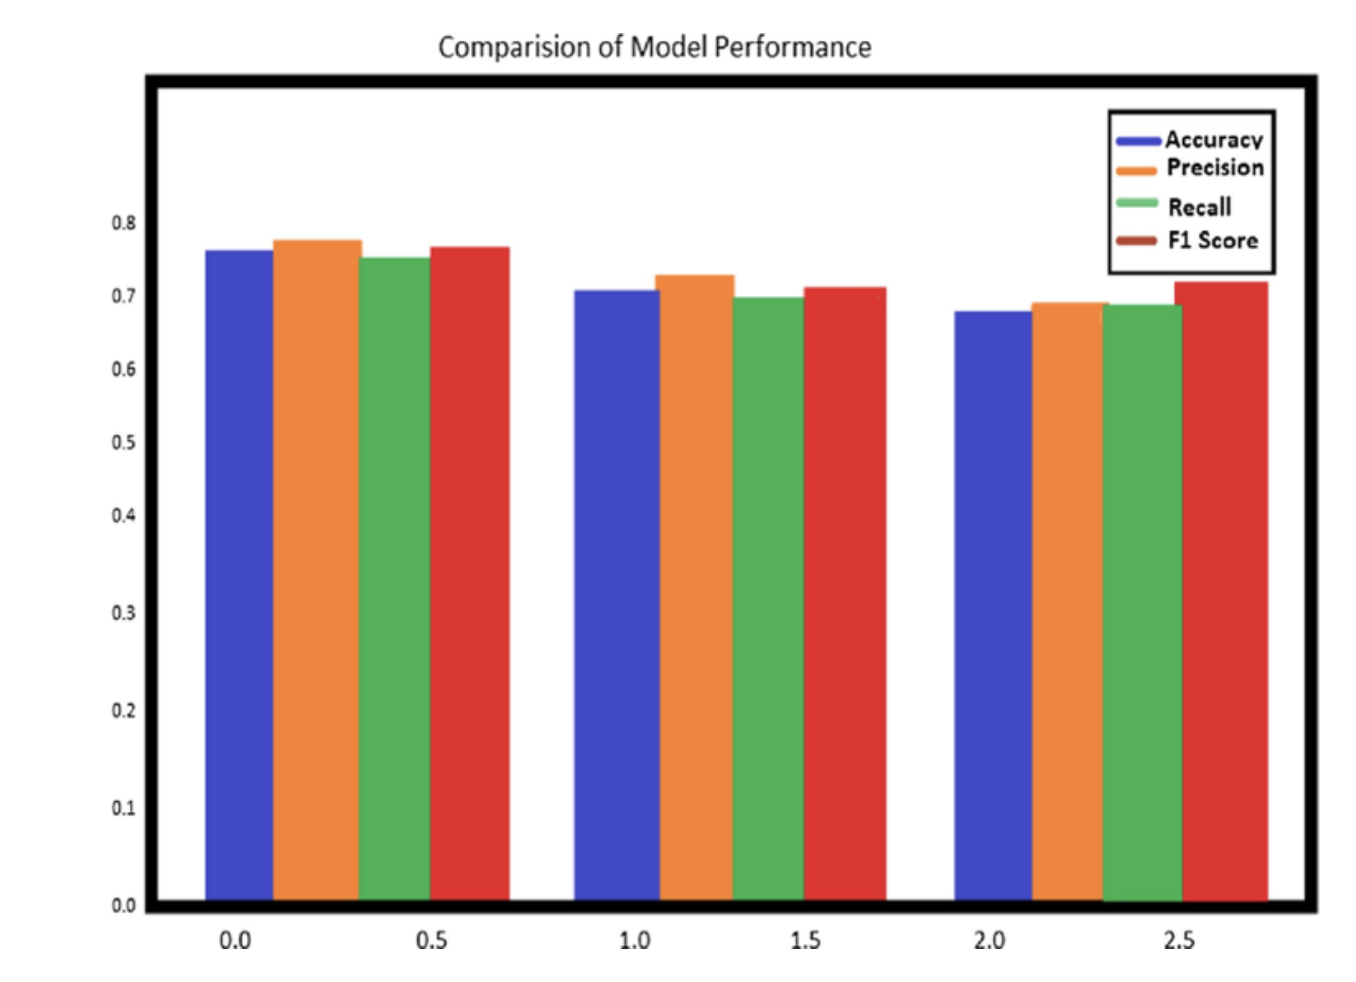

3. Statistics & Experimental Thinking

This is where your academic background is a major advantage.

In demand:

Probability distributions

Hypothesis testing

Confidence intervals

Regression assumptions

A/B testing logic

Bias & variance trade-offs

Interview framing:

“How do you know your result is meaningful?